In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [3]:
conn = sqlite3.connect(r'C:\Users\kenta\OneDrive\Desktop\Platinum Binar\database.db', check_same_thread=False)
query = 'SELECT * FROM new_data'
data = pd.read_sql_query (query, conn)
data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [4]:

# Membagi data berdasarkan label
data_dict = {}
for label in ['positive', 'neutral', 'negative']:
    data_dict[label] = data[data['Label'] == label]

# Menentukan jumlah sampel yang sama dari data 'neutral' dan 'negative'
sample_size = max(data_dict['neutral'].shape[0], data_dict['negative'].shape[0])

# Menggabungkan data
data = pd.concat([data_dict['positive'], data_dict['neutral'].sample(sample_size, replace=True), data_dict['negative']])

# Membuat list Tweet dan Label
tweet_dict = {}
label_dict = {}

for label in ['positive', 'neutral', 'negative']:
    tweet_dict[label] = data[data['Label'] == label].Tweet.tolist()
    label_dict[label] = data[data['Label'] == label].Label.tolist()



In [7]:
total_tweets_assemble = tweet_dict['positive'] + tweet_dict['negative'] + tweet_dict['neutral']

labels = label_dict['positive'] + label_dict['negative'] + label_dict['neutral']

print("Jumlah Value Positive: %s, Jumlah Value Neutral: %s, Jumlah Value Negative: %s" % (len(tweet_dict['positive']), len(tweet_dict['negative']), 
                                                   len(tweet_dict['neutral'])))
print("Total data text: %s" % len(total_tweets_assemble))
print("Total labels: %s" % len(labels))

Jumlah Value Positive: 6383, Jumlah Value Neutral: 3412, Jumlah Value Negative: 3412
Total data text: 13207
Total labels: 13207


Feature Extraction

Pemanfaatan tokenizer untuk melakukan ekstraksi data agar mudah diproses dalam modeling data.

In [8]:
max_features_tokenize = 100000
data_tokenizer = Tokenizer(num_words=max_features_tokenize, split=' ', lower=True)
data_tokenizer.fit_on_texts(total_tweets_assemble)

#Penyimpanan data TokenizerFile kedalam pickle
with open('TokenizerFile.pickle', 'wb') as file:
    pickle.dump(data_tokenizer, file , protocol=pickle.HIGHEST_PROTOCOL)
    print('File "TokenizerFile.pickle" telah tercetak!')

File "TokenizerFile.pickle" telah tercetak!


In [9]:
#Feature Extraction of X data
X = data_tokenizer.texts_to_sequences(total_tweets_assemble)
maxlen = max(len(x) for x in X)
X = pad_sequences(X)

#Penyimpanan data x_pad_sequences kedalam pickle
with open('x_pad_sequences.pickle', 'wb') as file:
    pickle.dump(X, file , protocol=pickle.HIGHEST_PROTOCOL)
    print('File "x_pad_sequences.pickle" telah tercetak!')


#Feature Extraction of Y data
y = pd.get_dummies(labels)
y = y.values

#Penyimpanan data x_target kedalam library pickle
with open('x_target.pickle', 'wb') as file:
    pickle.dump(y, file, protocol=pickle.HIGHEST_PROTOCOL)

File "x_pad_sequences.pickle" telah tercetak!


Train-Test Split Data

In [10]:
#Split train-test dataset
#Loading Dataset
x_file = open('x_pad_sequences.pickle', 'rb')
x = pickle.load(x_file)
x_file.close()

y_file = open('x_target.pickle', 'rb')
y = pickle.load(y_file)
y_file.close()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3, random_state=42)

In [11]:
#Pelatihan model menggunakan Train-Test Split
model = Sequential()
model.add(Embedding(max_features_tokenize, output_dim = 100, input_length = x.shape[1] ))
model.add(LSTM(units= 64, dropout=0.2))
model.add(Dense(units=y.shape[1], activation= 'softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam_optim = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam_optim, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(x_train, y_train, epochs=20, batch_size=32, 
                        validation_data=(x_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/20
289/289 [==============================] - 31s 101ms/step - loss: 0.8977 - accuracy: 0.5884 - val_loss: 0.7083 - val_accuracy: 0.6717
Epoch 2/20
289/289 [==============================] - 28s 97ms/step - loss: 0.6403 - accuracy: 0.7008 - val_loss: 0.5830 - val_a

In [12]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features_tokenize, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3, activation='softmax'))
    adam = optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def train_model(model, data_train, target_train, data_test, target_test):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])
    return model

# Inisialisasi KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []


embed_dim = 100
units = 64

# Iterasi melalui lipatan (folds) KFold
for iteration, data in enumerate(kf.split(X), start=1):
    data_train, target_train = X[data[0]], y[data[0]]
    data_test, target_test = X[data[1]], y[data[1]]

    model = create_model()
    trained_model = train_model(model, data_train, target_train, data_test, target_test)

    # Prediksi
    predictions = trained_model.predict(x_test)
    y_pred = predictions

    # Menghitung akurasi
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    # Menampilkan hasil
    print(f"Iterasi ke-{iteration}")
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# Menghitung rata-rata akurasi
average_accuracy = np.mean(accuracies)

print("\n\n\n")
print("Rata-rata Akurasi:", round(average_accuracy, 4))

Epoch 1/50
331/331 [==============================] - 30s 86ms/step - loss: 0.6411 - accuracy: 0.7250 - val_loss: 0.3771 - val_accuracy: 0.8626
Epoch 2/50
331/331 [==============================] - 28s 86ms/step - loss: 0.2805 - accuracy: 0.8973 - val_loss: 0.2591 - val_accuracy: 0.9054
Epoch 3/50
331/331 [==============================] - 28s 86ms/step - loss: 0.1737 - accuracy: 0.9410 - val_loss: 0.2641 - val_accuracy: 0.9050
Epoch 4/50
331/331 [==============================] - 79s 240ms/step - loss: 0.1206 - accuracy: 0.9600 - val_loss: 0.2633 - val_accuracy: 0.9118
Epoch 4: early stopping
124/124 [==============================] - 2s 10ms/step
Iterasi ke-1
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1040
           1       0.96      0.97      0.96       958
           2       0.94      0.95      0.94      1965

    accuracy                           0.93      3963
   macro avg       0.93      0.93      0.93      3963
weig

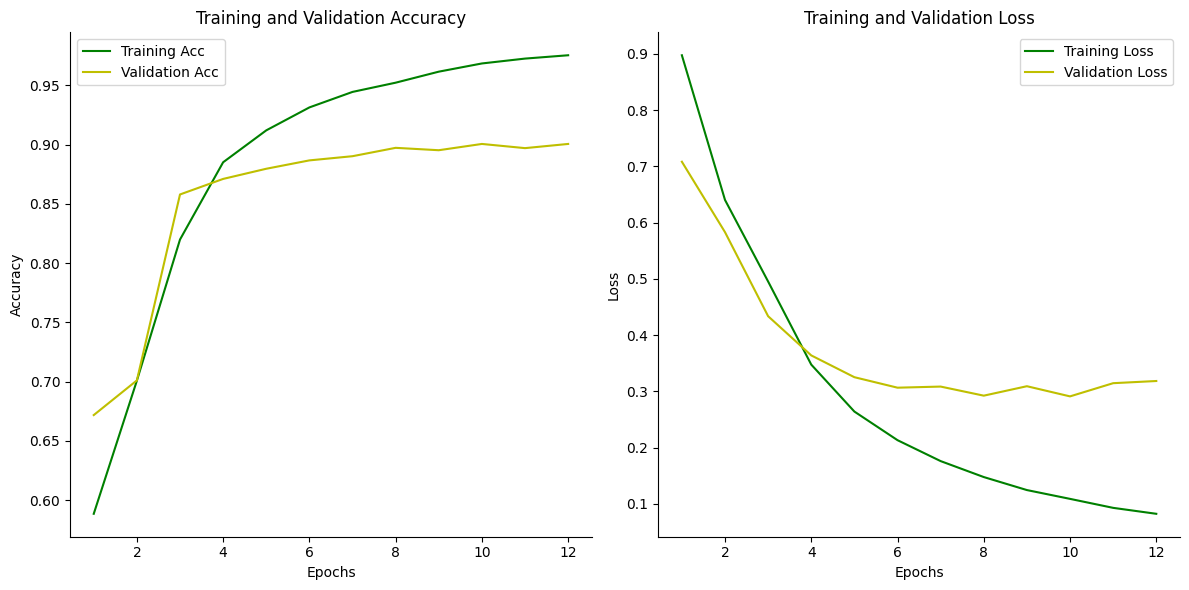

In [13]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Training Acc')
    plt.plot(epochs, val_acc, 'y', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    sns.despine()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    sns.despine()

    plt.tight_layout()
    plt.show()

# Memanggil fungsi plot_history untuk memvisualisasikan hasil
plot_history(history)

In [14]:
#Save model
trained_model.save('model.h5')
print('Model has created')


Model has created


C:\Users\kenta\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
input_text = """Dia memakan kue dengan lahap dan beringas jelek"""
def cleansing(text):
    text = text.lower()
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = text.replace('user', '')
    text = re.sub(' +', ' ', text)
    text = text.replace('\n', ' ')
    return text

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = data_tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 372ms/step
Text: dia memakan kue dengan lahap dan beringas jelek
Sentiment: negative
